# AIMNet2 QM9

## Import trainings

In [12]:
import glob
import importlib
import os
import sys
import statistics

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import wandb

import helper
from helper import extract_config, calculate_reference_energy
from modelforge.dataset.dataset import initialize_datamodule
from modelforge.dataset.utils import RandomRecordSplittingStrategy, SplittingStrategy
from modelforge.potential.potential import load_inference_model_from_checkpoint

sns.set_theme()
sns.set_context("notebook")
%matplotlib inline

In [13]:
api = wandb.Api()
runs = api.runs(
    "modelforge_nnps/aimnet2_qm9",
    # filters={"group": "exp09_2"},
)
print(f"Found {len(runs)} runs")
summary_list, config_list, name_list = [], [], []

Found 408 runs


In [14]:
extract_config(runs[0].config["training_parameter"], "tags")

{'tags': ['seed=42',
  'number_of_radial_basis_functions=32',
  'number_of_vector_features=4',
  'number_of_per_atom_features=64',
  '0.1.4+300.gef9c8be.dirty',
  'QM9',
  'AimNet2',
  'loss-per_system_energy',
  'loss-per_system_dipole_moment',
  'loss-per_atom_charge']}

In [15]:
runs[0].summary["val/per_system_energy/mae"]

5.104998588562012

In [16]:
exp_results = []

for run in runs:
    if run.state == "finished":
        record = {}
    
        record.update({"name": run.name})
        
        training_parameter = run.config["training_parameter"]
        potential_parameter = run.config['potential_parameter']
        tags = extract_config(training_parameter, "tags")["tags"]

        try:
            record.update({
                "test/per_system_energy/mae": run.summary["test/per_system_energy/mae"],
                "test/per_system_energy/rmse": run.summary["test/per_system_energy/rmse"],
                "test/per_system_dipole_moment/mae": run.summary["test/per_system_dipole_moment/mae"],
                "test/per_atom_charge/mae": run.summary["test/per_atom_charge/mae"],
                "test/per_atom_charge/rmse": run.summary["test/per_atom_charge/rmse"],

            })
        except KeyError:
            record.update({
                "test/per_system_energy/mae": pd.NA,
                "test/per_system_energy/rmse": pd.NA,
                "test/per_system_dipole_moment/mae": pd.NA,
                "test/per_atom_charge/mae": pd.NA,
            })
        record.update({
                "val/per_system_energy/mae": run.summary["val/per_system_energy/mae"],
                "val/per_system_energy/rmse": run.summary["val/per_system_energy/rmse"],
                "val/per_system_dipole_moment/mae": run.summary["val/per_system_dipole_moment/mae"],
                "val/per_atom_charge/mae": run.summary["val/per_atom_charge/mae"],
            })
        
        record.update(extract_config(potential_parameter, "number_of_radial_basis_functions"))
        record.update(extract_config(potential_parameter, "number_of_vector_features"))
        record.update(extract_config(potential_parameter, "number_of_per_atom_features"))

        loss_weights = extract_config(training_parameter, "weight")
        record.update(loss_weights["weight"])

        if "spin_multiplicity_embedding" in tags:
            record["spin_embedding"] = True
        else:
            record["spin_embedding"] = False

        record["group"] = run.group
        record.update(
            extract_config(training_parameter, "seed")
        )
        exp_results.append(record)

exp_results_df = pd.DataFrame(exp_results)

In [17]:
exp_results_df.sort_values(by="test/per_system_energy/mae").head(20)

,name,test/per_system_energy/mae,test/per_system_energy/rmse,test/per_system_dipole_moment/mae,test/per_atom_charge/mae,test/per_atom_charge/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,val/per_system_dipole_moment/mae,val/per_atom_charge/mae,number_of_radial_basis_functions,number_of_vector_features,number_of_per_atom_features,per_system_energy,per_system_dipole_moment,per_atom_charge,spin_embedding,group,seed
323,09(2)_32_4_512(46),3.032194,4.971966,65.123024,295.886597,327.715881,2.988077,4.735525,65.923370,295.517395,32,4,512,1.0,0.0,0.0,False,exp09_2,46
243,09(2)_32_4_512(45),3.087765,5.086136,43.336967,182.548584,215.956070,3.130801,5.098615,42.812763,182.476166,32,4,512,1.0,0.0,0.0,False,exp09_2,45
271,09(2)_64_16_512(45),3.135957,5.453893,120.702881,236.053284,309.021759,3.133974,5.185445,121.067772,236.171326,64,16,512,1.0,0.0,0.0,False,exp09_2,45
91,09(2)_64_8_512(43),3.200679,5.891709,50.058113,168.910706,210.843231,3.198044,7.032226,49.727837,169.448914,64,8,512,1.0,0.0,0.0,False,exp09_2,43
27,09(2)_64_8_512(42),3.246393,5.178706,82.035309,413.254547,453.641663,3.305224,5.184771,82.672356,413.219269,64,8,512,1.0,0.0,0.0,False,exp09_2,42
97,09(2)_32_8_256(43),3.276274,6.639567,146.530807,905.388367,1015.420105,3.199456,6.077083,146.050674,907.213074,32,8,256,1.0,0.0,0.0,False,exp09_2,43
107,09(2)_64_4_512(43),3.370919,6.532055,68.830566,269.453949,293.878754,3.351361,6.845793,69.109482,269.464508,64,4,512,1.0,0.0,0.0,False,exp09_2,43
203,09(2)_128_4_512(44),3.380081,5.738498,84.366028,215.471558,276.953888,3.400288,6.154714,84.805229,215.173874,128,4,512,1.0,0.0,0.0,False,exp09_2,44
167,09(2)_32_8_512(44),3.393395,5.353999,74.452362,335.610199,373.219635,3.414303,6.532186,74.674728,335.693115,32,8,512,1.0,0.0,0.0,False,exp09_2,44
267,09(2)_64_8_512(45),3.440671,5.87795,99.234306,491.872742,557.407043,3.408915,5.445519,99.755791,491.544830,64,8,512,1.0,0.0,0.0,False,exp09_2,45


In [18]:
exp_results_df.sort_values(by="test/per_system_energy/mae").tail(50)

,name,test/per_system_energy/mae,test/per_system_energy/rmse,test/per_system_dipole_moment/mae,test/per_atom_charge/mae,test/per_atom_charge/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,val/per_system_dipole_moment/mae,val/per_atom_charge/mae,number_of_radial_basis_functions,number_of_vector_features,number_of_per_atom_features,per_system_energy,per_system_dipole_moment,per_atom_charge,spin_embedding,group,seed
317,09(2)_256_64_128(45),10.968306,17.00782,8932.995117,42979.804688,47103.867188,11.172601,16.665537,8936.244141,42994.468750,256,64,128,1.0,0.0,0.0,False,exp09_2,45
230,09(2)_256_16_256(44),11.09552,15.793065,4065.907471,11693.623047,13058.706055,11.278869,16.930792,4054.064697,11708.715820,256,16,256,1.0,0.0,0.0,False,exp09_2,44
366,09(2)_128_16_64(46),11.104708,15.754149,1509.596069,11204.533203,12855.682617,10.999353,15.313608,1503.796509,11205.124023,128,16,64,1.0,0.0,0.0,False,exp09_2,46
229,09(2)_256_16_128(44),11.280036,15.703368,2212.586182,11862.661133,12896.900391,11.443386,16.879402,2194.375000,11862.360352,256,16,128,1.0,0.0,0.0,False,exp09_2,44
313,09(2)_256_32_128(45),11.286842,16.383015,1724.110596,8695.044922,9607.760742,11.179496,16.637316,1725.251465,8699.561523,256,32,128,1.0,0.0,0.0,False,exp09_2,45
105,09(2)_256_64_256(42),11.382595,16.426159,9851.849609,48951.0625,54528.273438,11.447475,17.581196,9854.977539,48930.355469,256,64,256,1.0,0.0,0.0,False,exp09_2,42
212,09(2)_128_32_64(44),11.511496,16.310753,3411.987305,22541.458984,24721.453125,11.622747,16.796124,3402.819580,22577.794922,128,32,64,1.0,0.0,0.0,False,exp09_2,44
309,09(2)_256_16_128(45),11.551919,16.854034,3259.633789,16351.625977,18064.406250,11.548080,16.929270,3252.637451,16362.499023,256,16,128,1.0,0.0,0.0,False,exp09_2,45
56,09(2)_128_64_64(42),11.875813,16.63015,9659.487305,46745.515625,51765.648438,12.130034,17.214294,9623.145508,46739.242188,128,64,64,1.0,0.0,0.0,False,exp09_2,42
156,09(2)_256_64_64(43),11.970592,17.921759,5538.977051,38709.117188,41962.695312,11.943542,17.918360,5495.667480,38796.699219,256,64,64,1.0,0.0,0.0,False,exp09_2,43


## Plotting training results

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context("notebook")

### Dataset splitting consistency

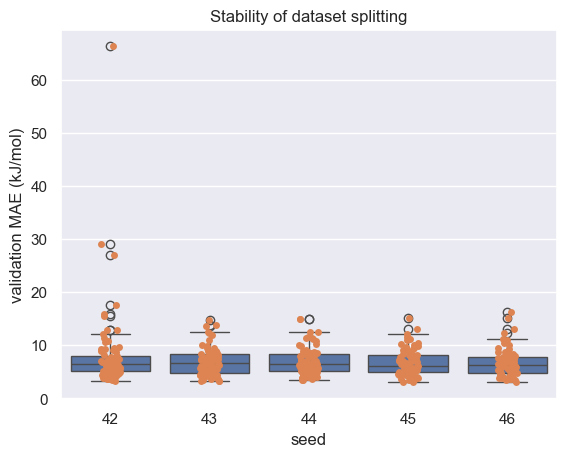

In [20]:
ax = sns.boxplot(
    data=exp_results_df,
    x="seed",
    y="val/per_system_energy/mae",
)
sns.stripplot(
    data=exp_results_df, 
    x="seed", 
    y="val/per_system_energy/mae", 
    legend=False,
)
ax.set_ylabel("validation MAE (kJ/mol)")
ax.set_title("Stability of dataset splitting")
# ax.set_ylim(45, 90)
plt.show()

In [21]:
exp_results_df = exp_results_df[exp_results_df["group"] == "exp09_2"]
exp_results_df['test/per_system_energy/mae'] = pd.to_numeric(
    exp_results_df['test/per_system_energy/mae'], errors='coerce'
)

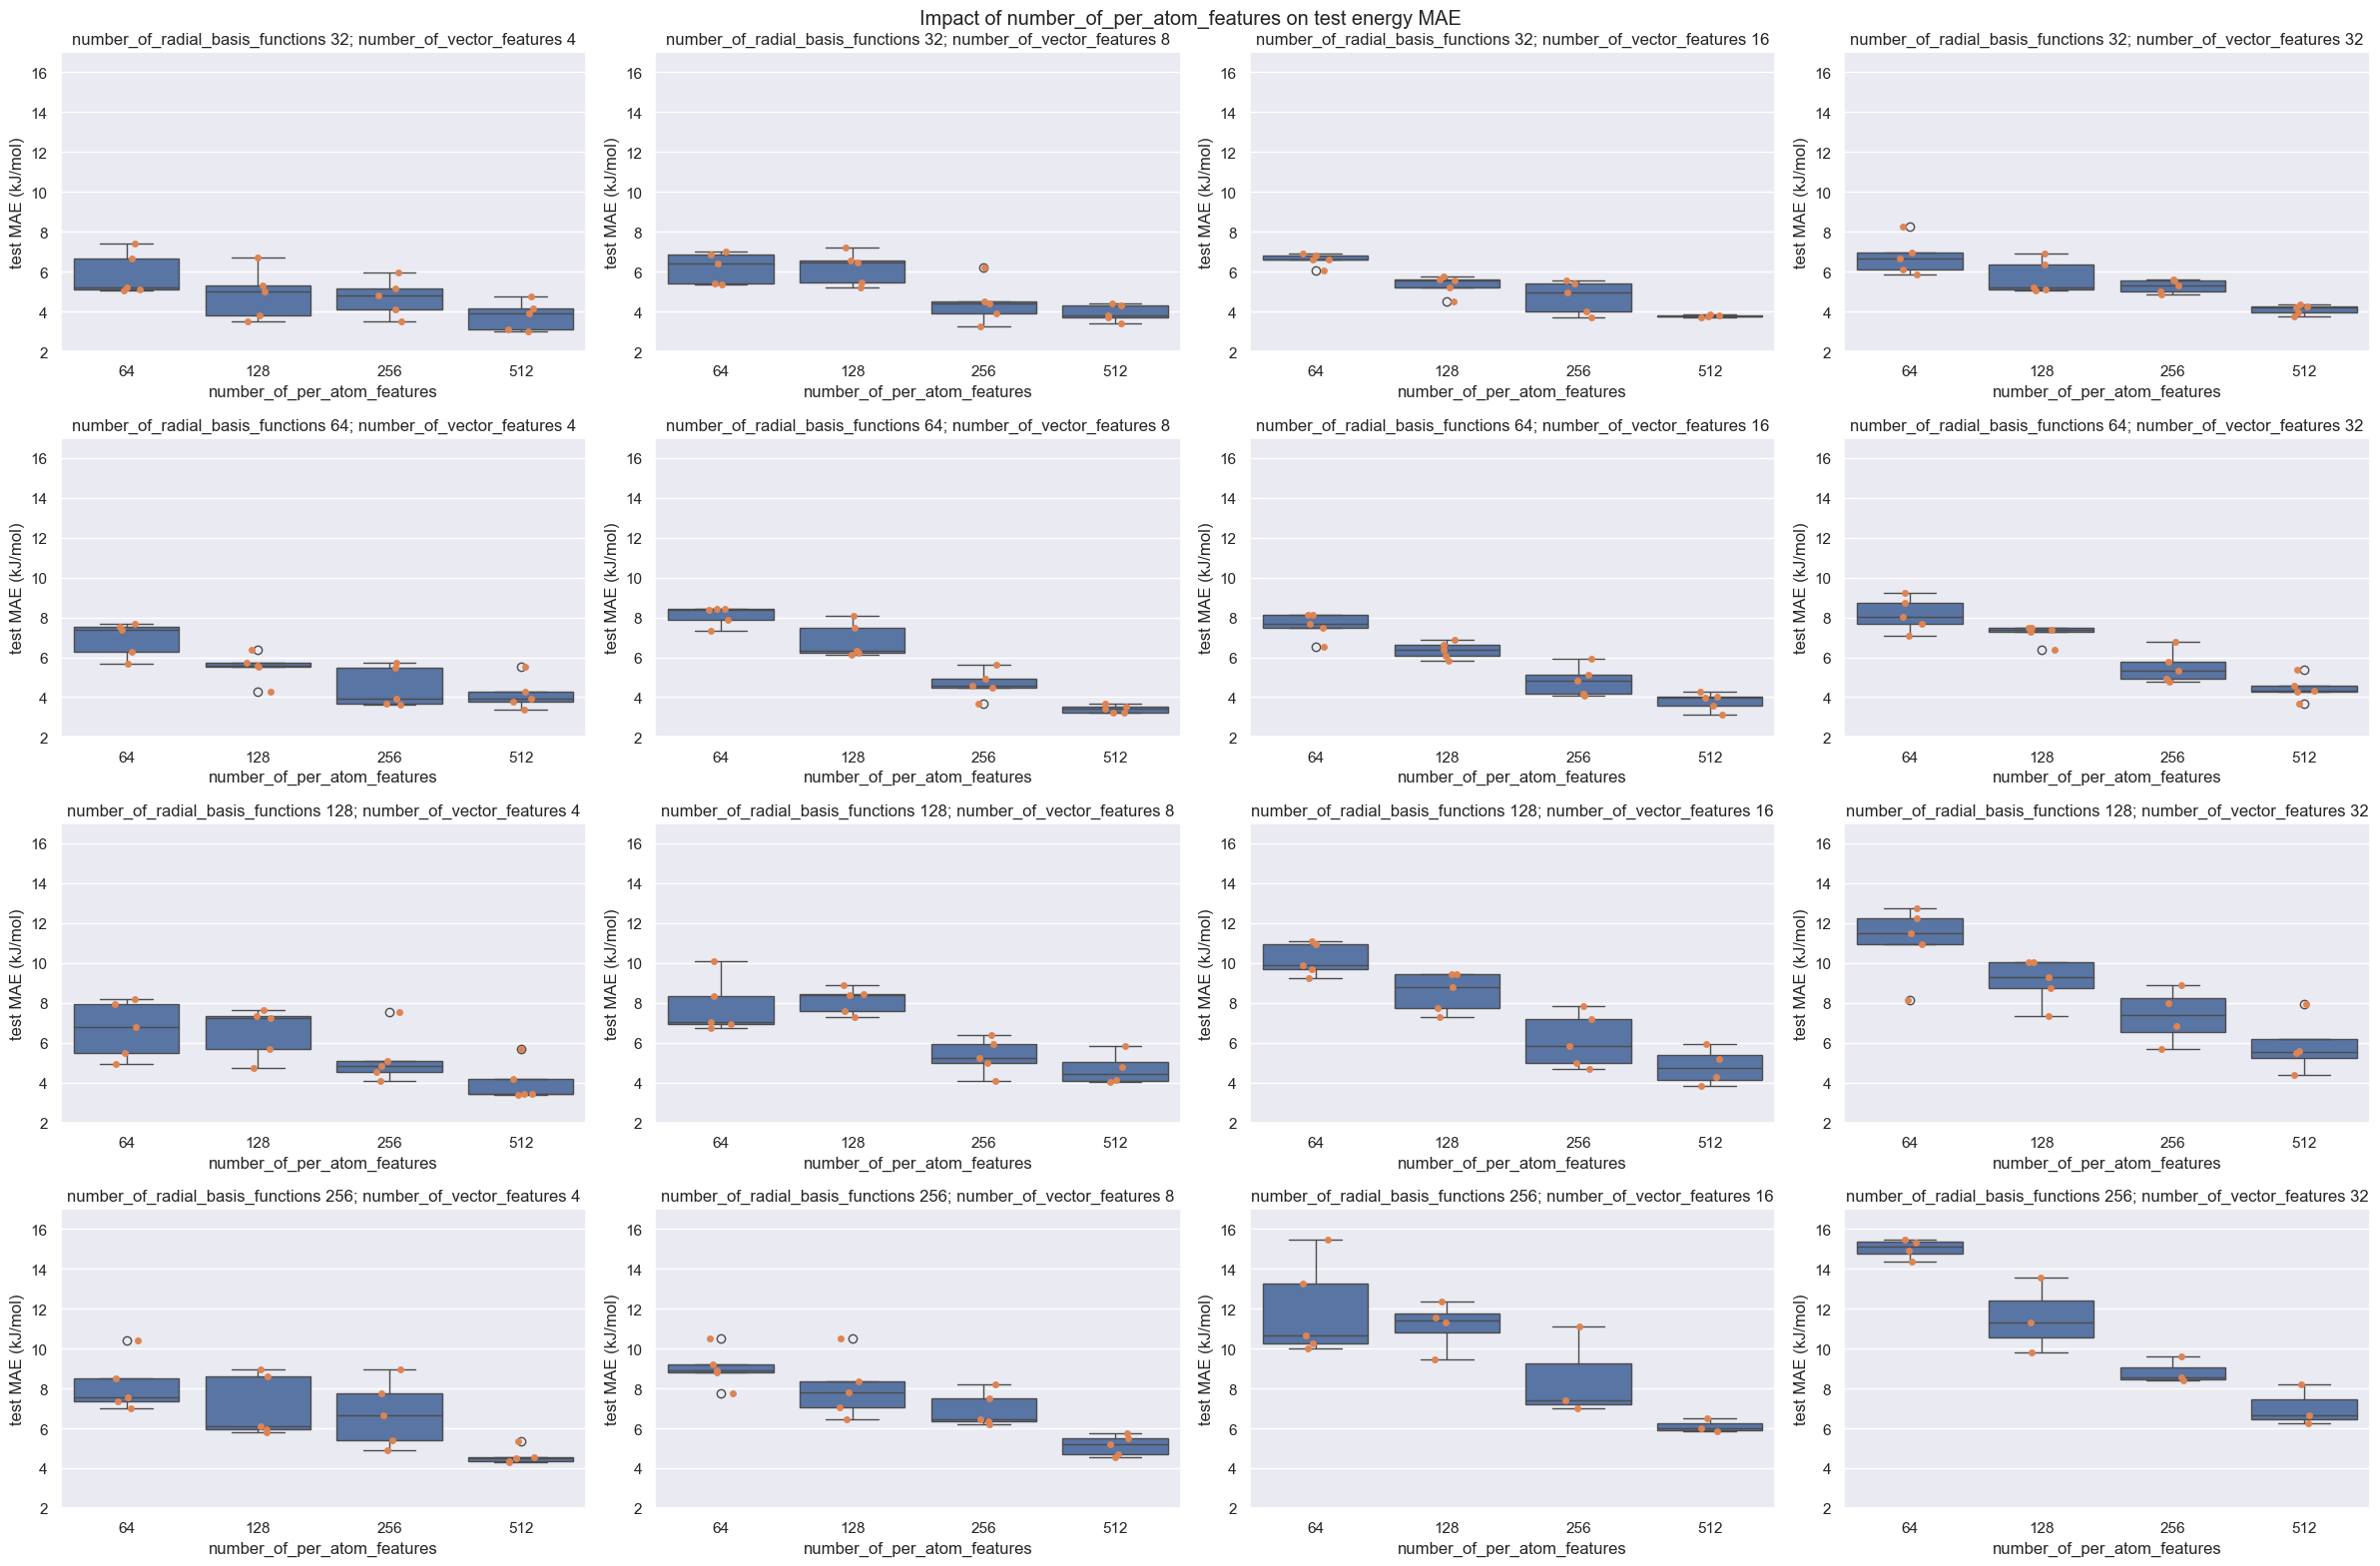

In [22]:
fig, axes = plt.subplots(4, 4, figsize=(24, 16))
fig.suptitle("Impact of number_of_per_atom_features on test energy MAE")

for i, number_of_radial_basis_functions in enumerate([32, 64, 128, 256]):
    for j, number_of_vector_features in enumerate([4, 8, 16, 32]):
        plot_results = exp_results_df[
            (exp_results_df["number_of_radial_basis_functions"] == number_of_radial_basis_functions) & \
            (exp_results_df["number_of_vector_features"] == number_of_vector_features)
        ]
        sns.boxplot(
            ax=axes[i, j],
            data=plot_results,
            x="number_of_per_atom_features",
            y="test/per_system_energy/mae",
            # hue="group",
        )
        sns.stripplot(
            ax=axes[i, j],
            data=plot_results, 
            x="number_of_per_atom_features",
            y="test/per_system_energy/mae",
            # hue="group",
            # legend=False,
        )
        axes[i, j].set_ylim(2, 17)
        axes[i, j].set_ylabel("test MAE (kJ/mol)")
        axes[i, j].set_title(f"number_of_radial_basis_functions {number_of_radial_basis_functions}; number_of_vector_features {number_of_vector_features}")

fig.tight_layout()

In [25]:
exp_results_df = exp_results_df[exp_results_df["number_of_per_atom_features"] == 512]

### Impact of number_of_vector_features v.s. number_of_radial_basis_functions

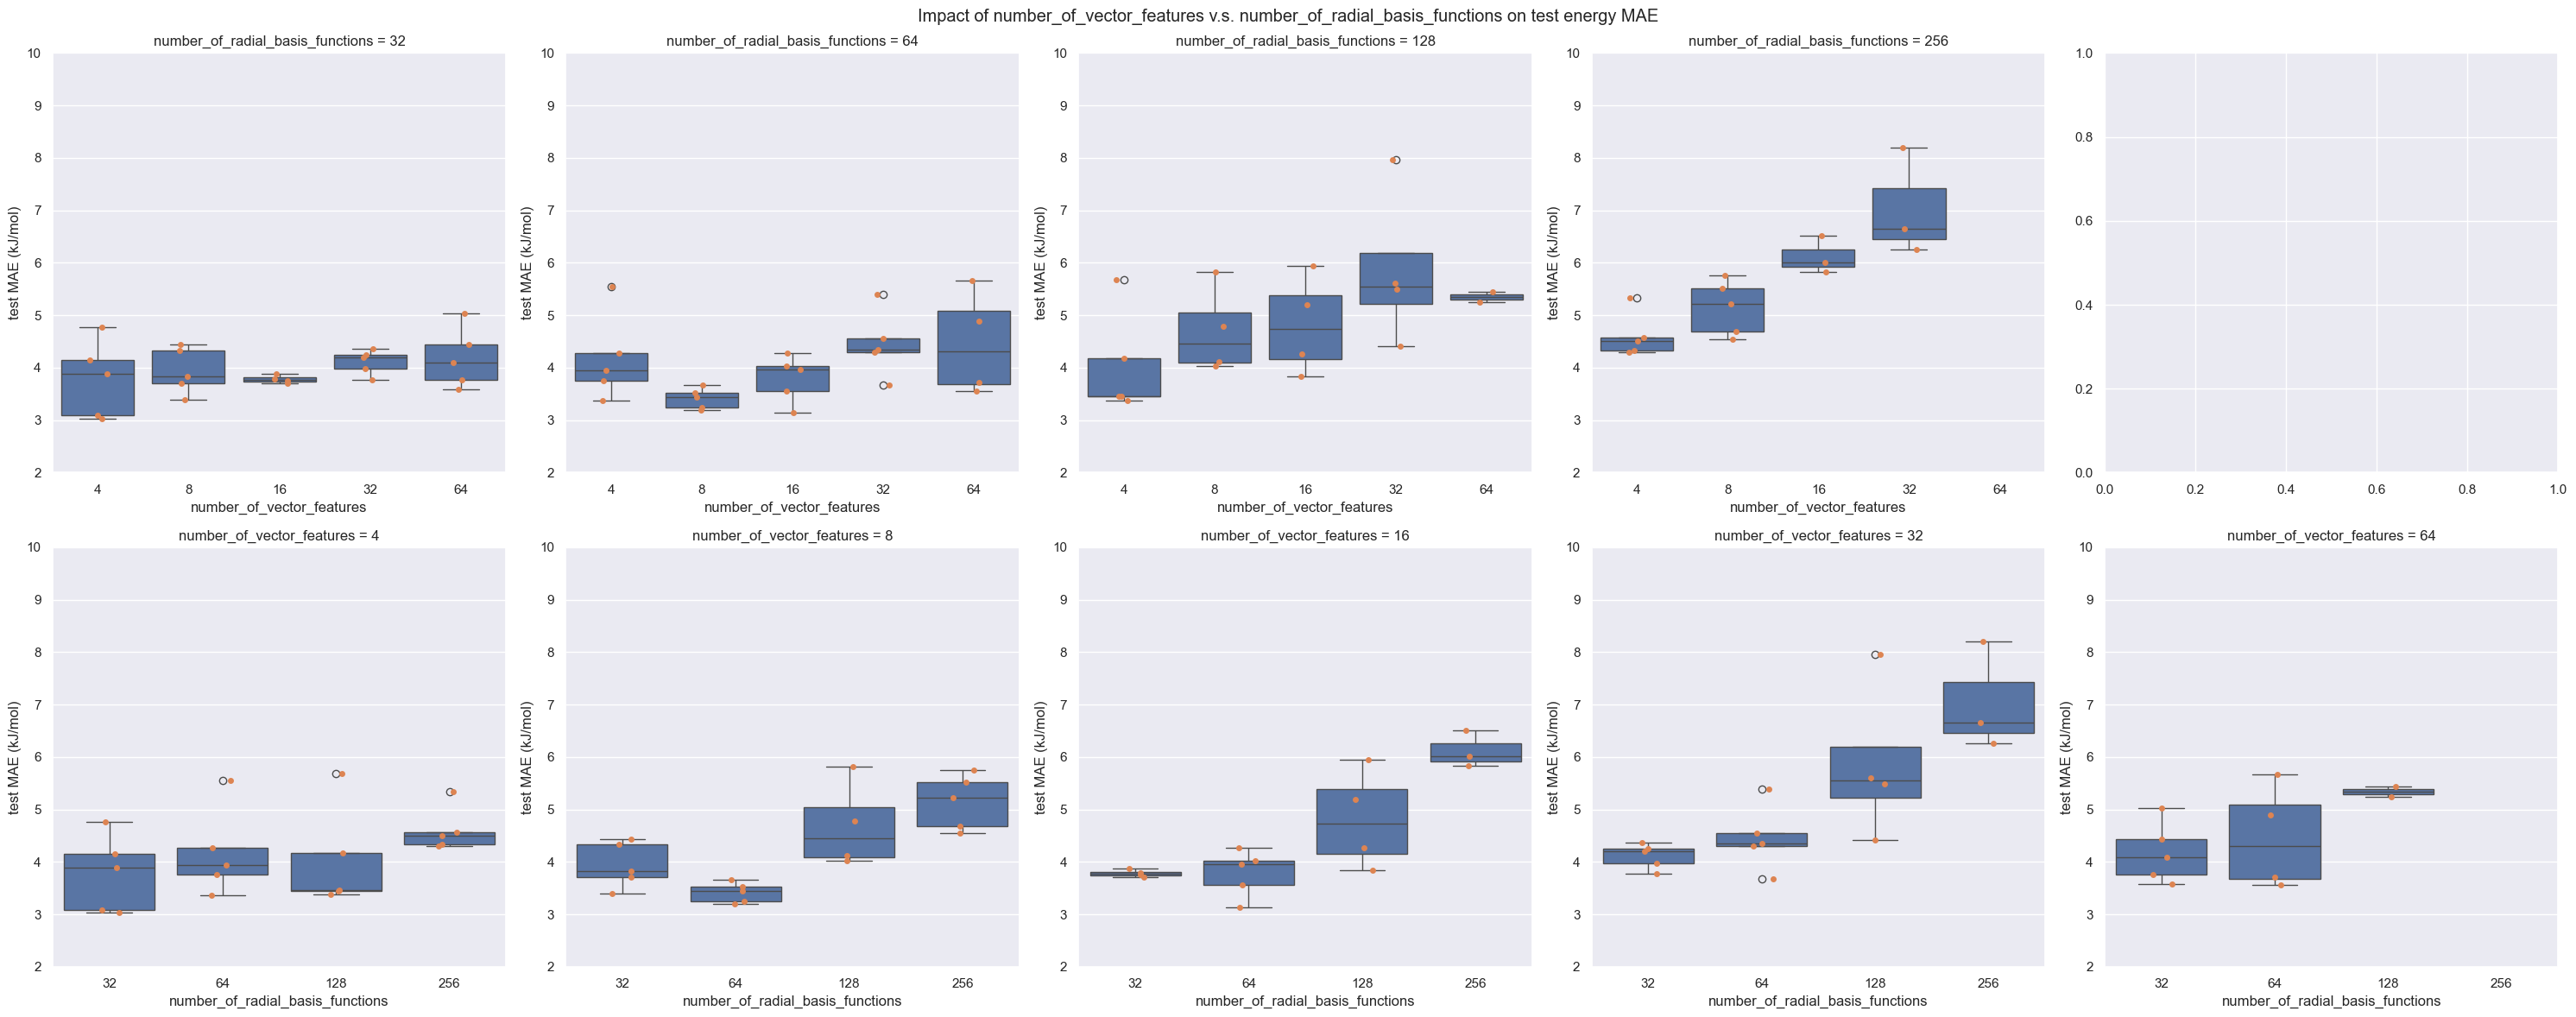

In [26]:
fig, axes = plt.subplots(2, 5, figsize=(30, 12))
fig.suptitle("Impact of number_of_vector_features v.s. number_of_radial_basis_functions on test energy MAE")

for i, number_of_radial_basis_functions in enumerate([32, 64, 128, 256]):
    sns.boxplot(
        ax=axes[0, i],
        data=exp_results_df[exp_results_df["number_of_radial_basis_functions"] == number_of_radial_basis_functions],
        x="number_of_vector_features",
        y="test/per_system_energy/mae",
    )
    sns.stripplot(
        ax=axes[0, i],
        data=exp_results_df[exp_results_df["number_of_radial_basis_functions"] == number_of_radial_basis_functions],
        x="number_of_vector_features",
        y="test/per_system_energy/mae",
        # hue="total_charge_embedding",
        # legend=False,
    )
    axes[0, i].set_ylim(2, 10)
    axes[0, i].set_ylabel("test MAE (kJ/mol)")
    axes[0, i].set_title(f"number_of_radial_basis_functions = {number_of_radial_basis_functions}")

for i, number_of_vector_features in enumerate([4, 8, 16, 32, 64]):
    sns.boxplot(
        ax=axes[1, i],
        data=exp_results_df[exp_results_df["number_of_vector_features"] == number_of_vector_features],
        x="number_of_radial_basis_functions",
        y="test/per_system_energy/mae",
    )
    sns.stripplot(
        ax=axes[1, i],
        data=exp_results_df[exp_results_df["number_of_vector_features"] == number_of_vector_features],
        x="number_of_radial_basis_functions",
        y="test/per_system_energy/mae",
    )
    axes[1, i].set_ylim(2, 10)
    axes[1, i].set_ylabel("test MAE (kJ/mol)")
    axes[1, i].set_title(f"number_of_vector_features = {number_of_vector_features}")

fig.tight_layout()

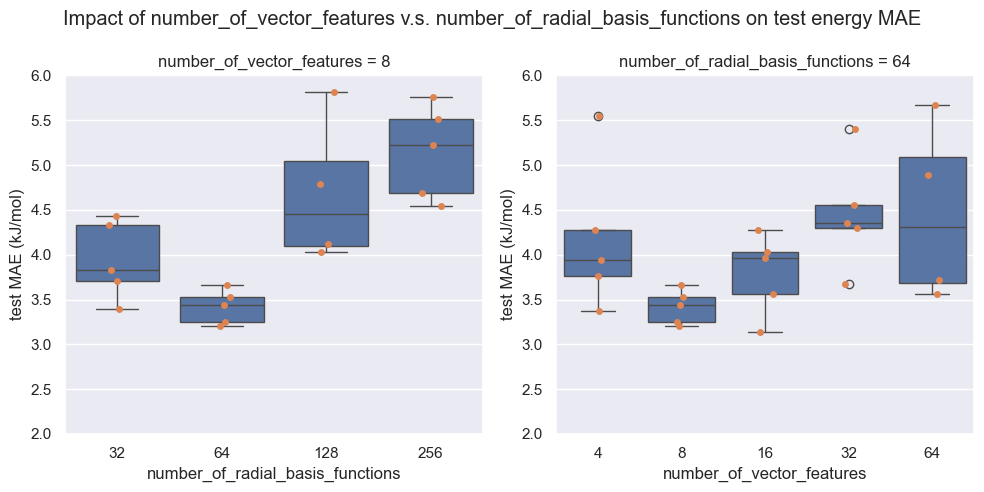

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Impact of number_of_vector_features v.s. number_of_radial_basis_functions on test energy MAE")

sns.boxplot(
    ax=axes[0],
    data=exp_results_df[exp_results_df["number_of_vector_features"] == 8],
    x="number_of_radial_basis_functions",
    y="test/per_system_energy/mae",
)
sns.stripplot(
    ax=axes[0],
    data=exp_results_df[exp_results_df["number_of_vector_features"] == 8],
    x="number_of_radial_basis_functions",
    y="test/per_system_energy/mae",
)
axes[0].set_ylim(2, 6)
axes[0].set_ylabel("test MAE (kJ/mol)")
axes[0].set_title("number_of_vector_features = 8")

sns.boxplot(
    ax=axes[1],
    data=exp_results_df[exp_results_df["number_of_radial_basis_functions"] == 64],
    x="number_of_vector_features",
    y="test/per_system_energy/mae",
)
sns.stripplot(
    ax=axes[1],
    data=exp_results_df[exp_results_df["number_of_radial_basis_functions"] == 64],
    x="number_of_vector_features",
    y="test/per_system_energy/mae",
)
axes[1].set_ylim(2, 6)
axes[1].set_ylabel("test MAE (kJ/mol)")
axes[1].set_title("number_of_radial_basis_functions = 64")

fig.tight_layout()

### Heat maps

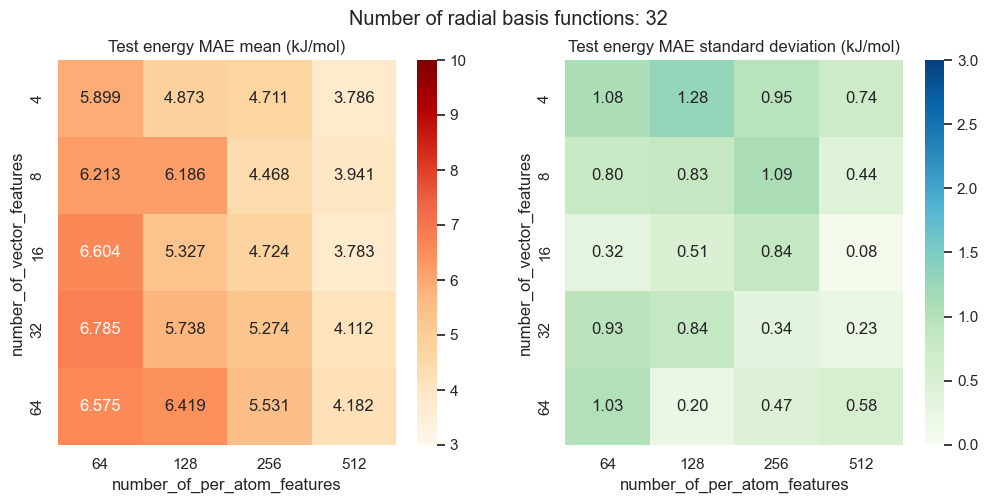

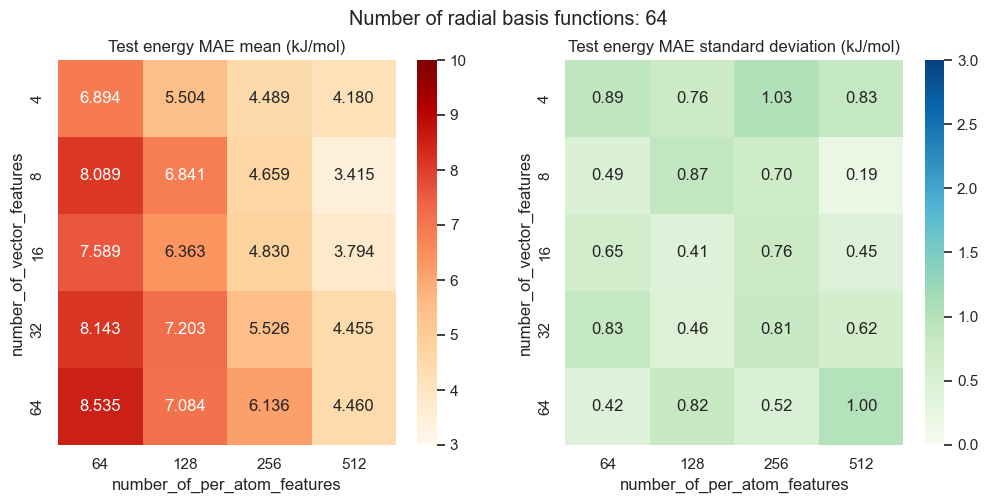

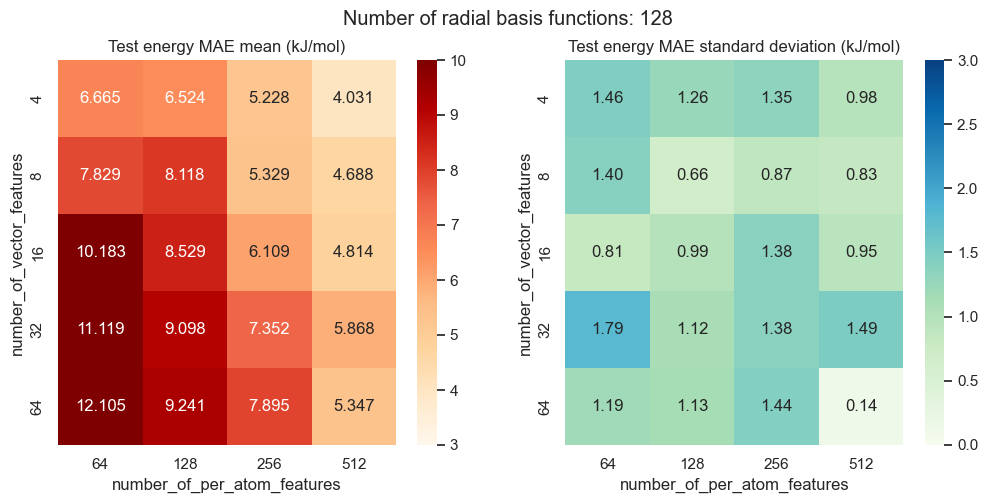

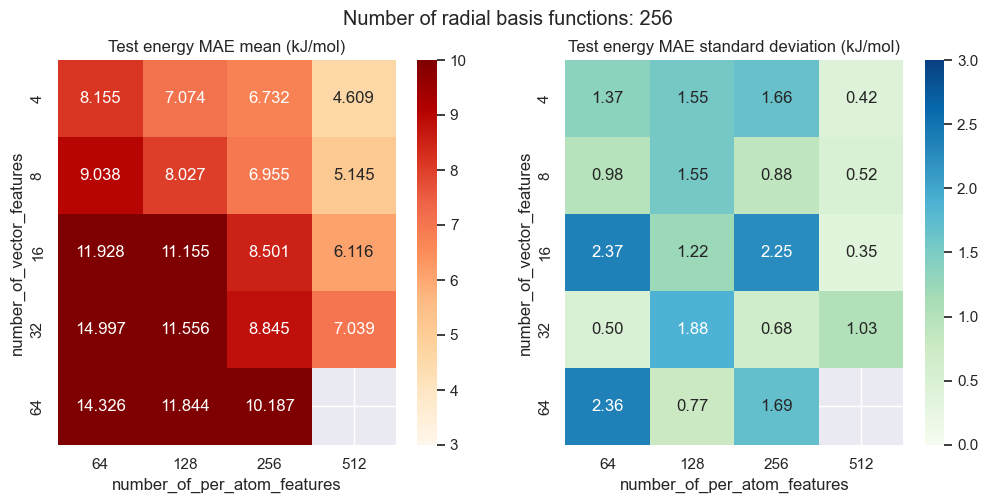

In [24]:
for i in [32, 64, 128, 256]:
    mean_heatmap_df = exp_results_df[exp_results_df["number_of_radial_basis_functions"] == i][["number_of_per_atom_features", "number_of_vector_features", "test/per_system_energy/mae"]].groupby(["number_of_vector_features", "number_of_per_atom_features"]).agg("mean").reset_index()
    std_heatmap_df = exp_results_df[exp_results_df["number_of_radial_basis_functions"] == i][["number_of_per_atom_features", "number_of_vector_features", "test/per_system_energy/mae"]].groupby(["number_of_vector_features", "number_of_per_atom_features"]).agg("std").reset_index()
    mean_heatmap_df = mean_heatmap_df.pivot(
        index="number_of_vector_features",
        columns="number_of_per_atom_features",
        values="test/per_system_energy/mae",
    )
    std_heatmap_df = std_heatmap_df.pivot(
        index="number_of_vector_features",
        columns="number_of_per_atom_features",
        values="test/per_system_energy/mae",
    )
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Number of radial basis functions: {i}")
    sns.heatmap(
        ax=axes[0],
        data=mean_heatmap_df,
        annot=True, 
        fmt=".3f",
        cmap='OrRd',
        vmin=3,
        vmax=10,
    )
    axes[0].set_title("Test energy MAE mean (kJ/mol)")
    sns.heatmap(
        ax=axes[1],
        data=std_heatmap_df,
        annot=True, 
        fmt=".2f",
        cmap='GnBu',
        vmin=0,
        vmax=3,
    )
    axes[1].set_title("Test energy MAE standard deviation (kJ/mol)")